# CNN pretrained ResNet50 model 

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and loading Data

In [42]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from time import sleep 

import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 16

### Loading (augmented) metadata as test, train, validation from files

In [43]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

lesion_id                    image_id     dx    dx_type   age     sex   
271   HAM_0005170            ISIC_0026253.jpg     nv  follow_up  80.0    male  \
1696  HAM_0006898            ISIC_0031040.jpg  akiec      histo  80.0    male   
2103  HAM_0000688  aug_ea9T6EISIC_0026720.jpg  akiec      histo  75.0    male   
988   HAM_0000383            ISIC_0024612.jpg    bkl      histo  85.0    male   
1906  HAM_0005459  aug_R8ooZ2ISIC_0032397.jpg  akiec      histo  85.0    male   
2388  HAM_0002194            ISIC_0025814.jpg    mel      histo  65.0    male   
453   HAM_0001790            ISIC_0032739.jpg     nv      histo  70.0    male   
4272  HAM_0005989  aug_ThN2o3ISIC_0033565.jpg   vasc      histo  25.0  female   
3725  HAM_0004365  aug_BLmIx1ISIC_0031294.jpg    bcc      histo  80.0    male   
408   HAM_0005919            ISIC_0030503.jpg     nv  follow_up  60.0    male   
539   HAM_0001547            ISIC_0034209.jpg     nv      histo  25.0    male   
3554  HAM_0005396  aug_xxw6J4ISIC_0034255.jpg    bcc      histo  75.0    male   
643   HAM_0006508            ISIC_0030342.jpg     nv  follow_up  50.0  female   
1265  HAM_0001603            ISIC_0031016.jpg    bkl      histo  70.0    male   
1240  HAM_0004422            ISIC_0030700.jpg    bkl      histo  70.0  female   

         localization        dataset        dx_binary     dx_tertiary   
271             trunk  vidir_molemax  not_skin_cancer          benign  \
1696            scalp      rosendahl      skin_cancer       malignant   
2103  lower extremity      rosendahl      skin_cancer       malignant   
988              back      rosendahl  not_skin_cancer  non-neoplastic   
1906  upper extremity      rosendahl      skin_cancer       malignant   
2388             back      rosendahl      skin_cancer       malignant   
453           abdomen   vidir_modern  not_skin_cancer          benign   
4272             back   vidir_modern  not_skin_cancer  non-neoplastic   
3725             face      rosendahl      skin_cancer       malignant   
408           abdomen  vidir_molemax  not_skin_cancer          benign   
539   lower extremity   vidir_modern  not_skin_cancer          benign   
3554          abdomen   vidir_modern      skin_cancer       malignant   
643              foot  vidir_molemax  not_skin_cancer          benign   
1265             back      rosendahl  not_skin_cancer  non-neoplastic   
1240  upper extremity      rosendahl  not_skin_cancer  non-neoplastic   

                                     image_path  
271             ./../data/jpgs/ISIC_0026253.jpg  
1696            ./../data/jpgs/ISIC_0031040.jpg  
2103  ./../data/jpgs/aug_ea9T6EISIC_0026720.jpg  
988             ./../data/jpgs/ISIC_0024612.jpg  
1906  ./../data/jpgs/aug_R8ooZ2ISIC_0032397.jpg  
2388            ./../data/jpgs/ISIC_0025814.jpg  
453             ./../data/jpgs/ISIC_0032739.jpg  
4272  ./../data/jpgs/aug_ThN2o3ISIC_0033565.jpg  
3725  ./../data/jpgs/aug_BLmIx1ISIC_0031294.jpg  
408             ./../data/jpgs/ISIC_0030503.jpg  
539             ./../data/jpgs/ISIC_0034209.jpg  
3554  ./../data/jpgs/aug_xxw6J4ISIC_0034255.jpg  
643             ./../data/jpgs/ISIC_0030342.jpg  
1265            ./../data/jpgs/ISIC_0031016.jpg  
1240            ./../data/jpgs/ISIC_0030700.jpg

## Setting up the image data generator for training and validation

#### Function for custom preprocessing of the images

In [44]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

#### Data Image generator for Train and Validation

In [45]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    zoom_range=0.2,              # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    shear_range=0.2,             # Shear intensity (shear angle in radians)
    fill_mode='nearest'          # Strategy for filling in newly created pixels after transformations
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    #save_to_dir=FILEPATH_OUTPUT,
    #save_prefix="test_gen_",
    #save_format="jpg",
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


### Control: Show some images from the train data set after preprocessing

In [46]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [47]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.007843138 1.0 float32


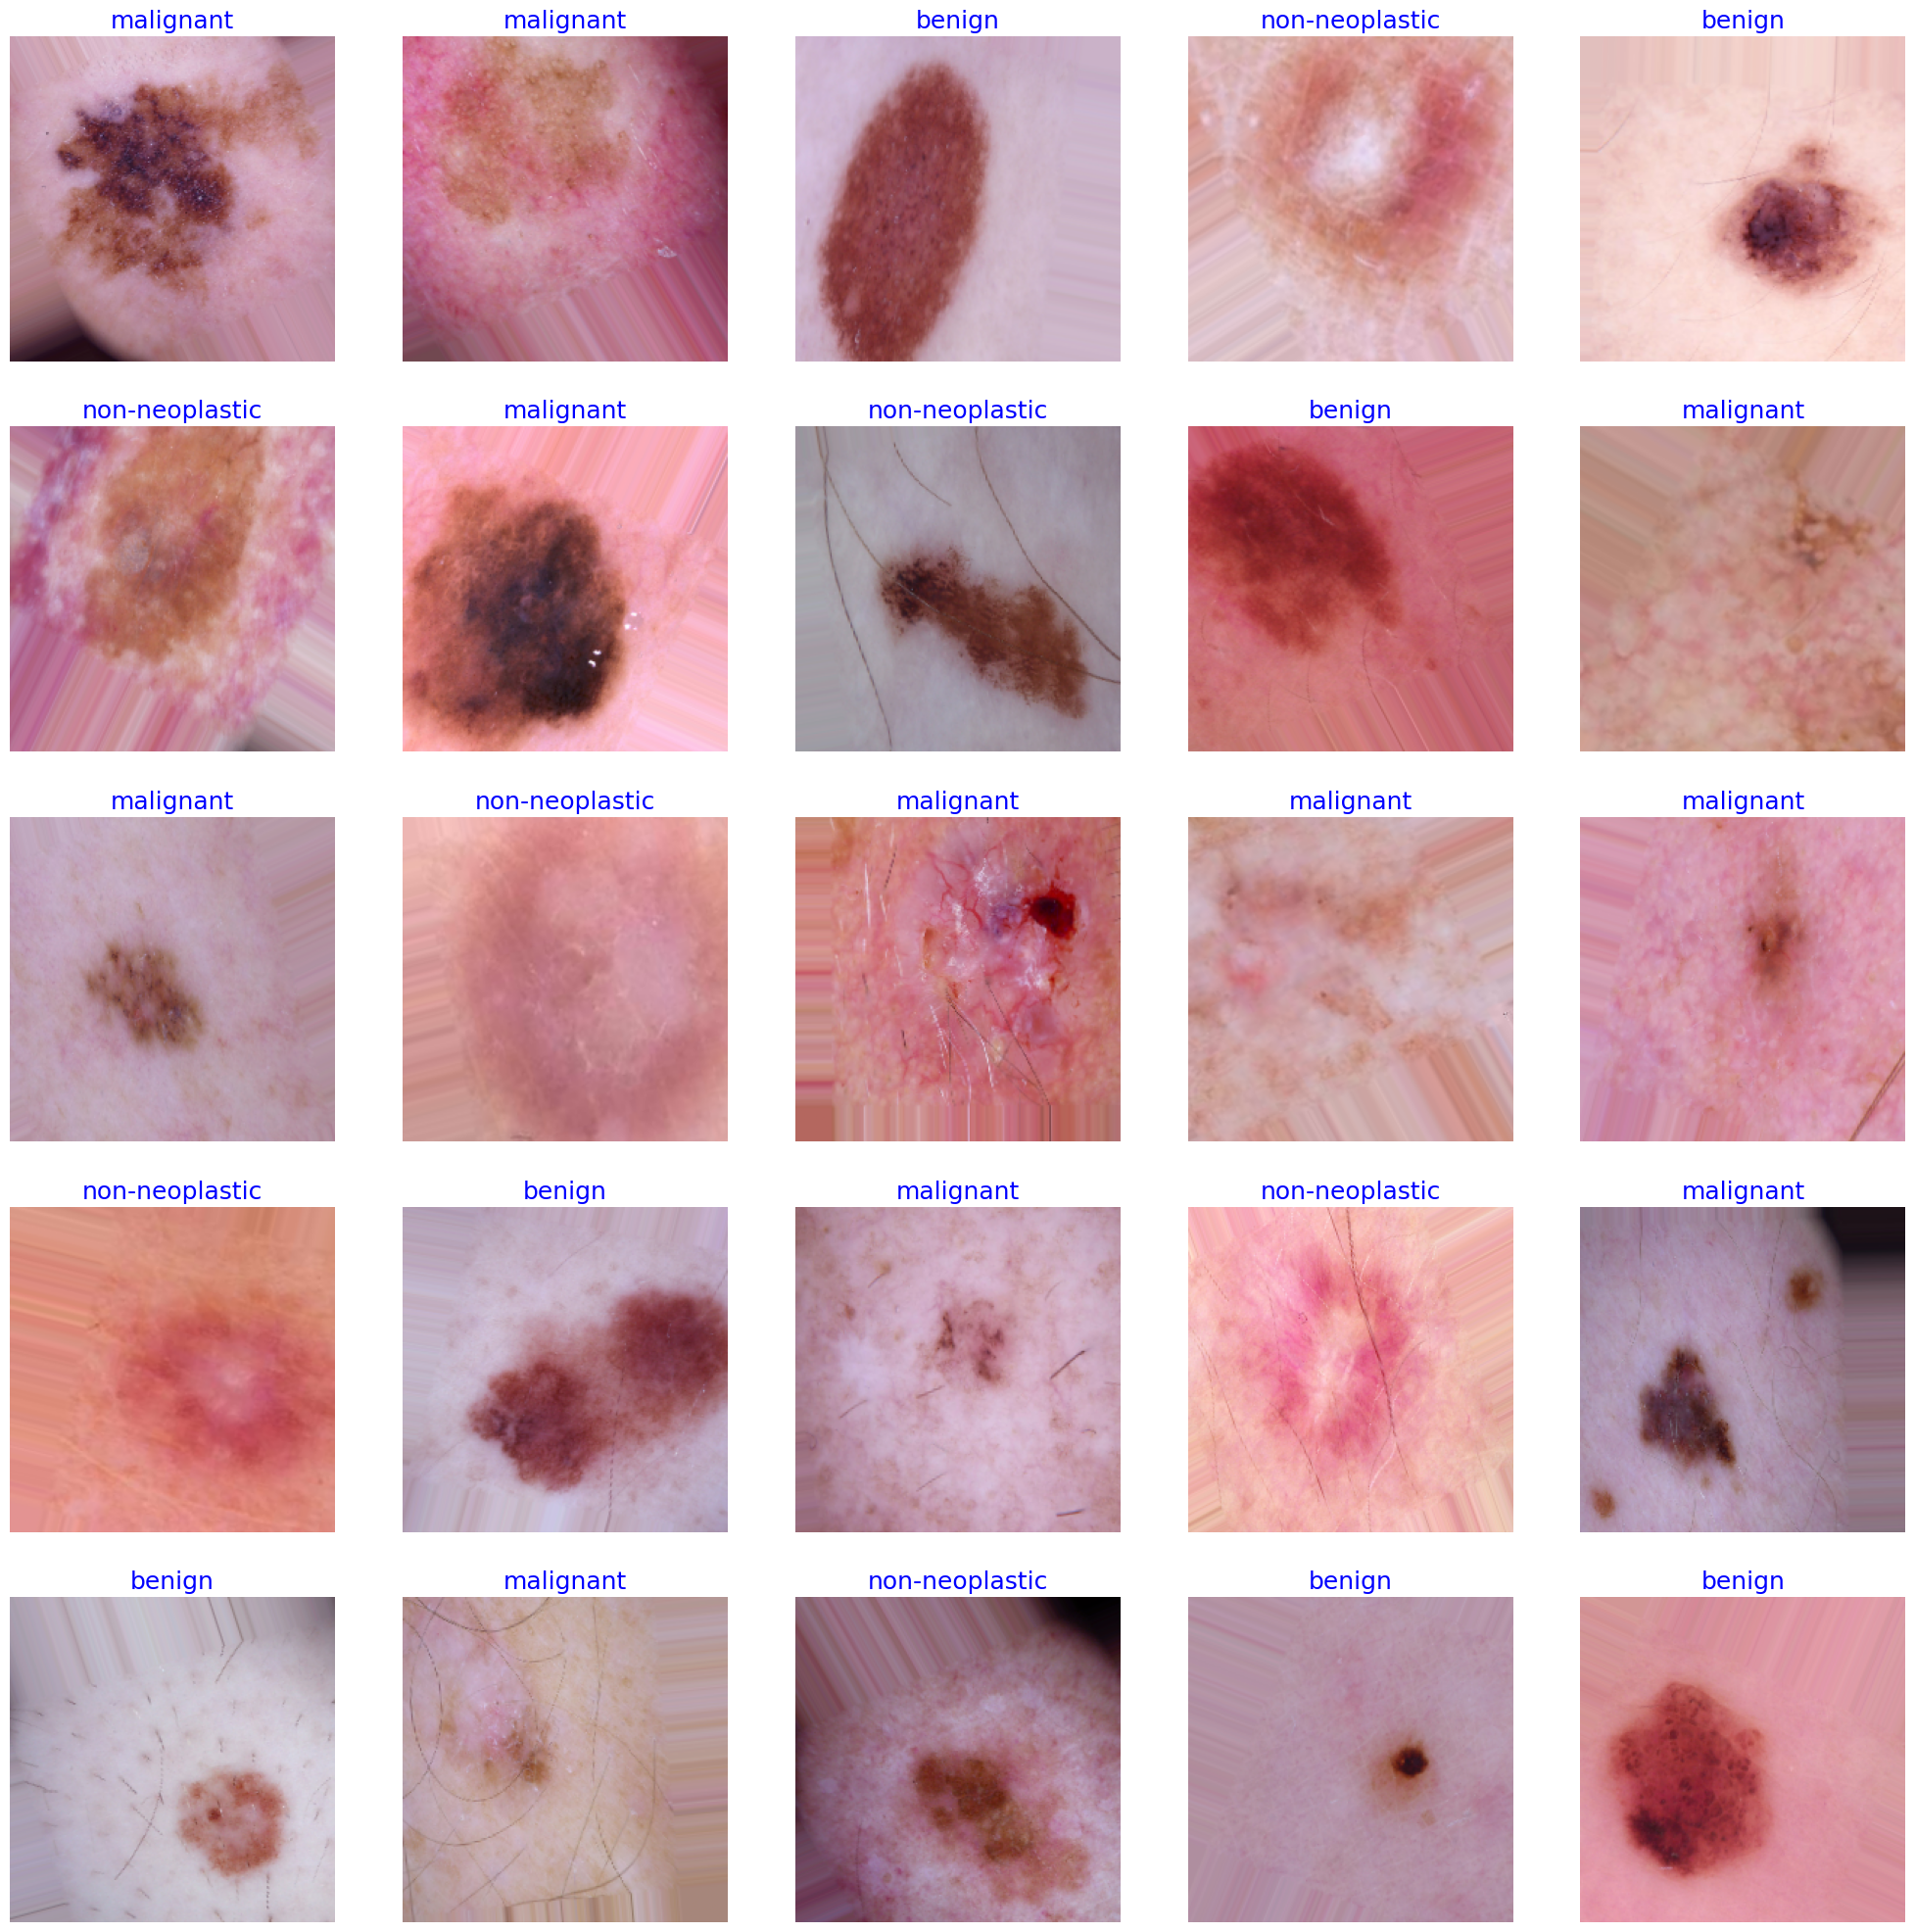

In [48]:
show_image_samples(train_data_generator)

## ResNet50


#### F1 score metric function for model compilation

In [49]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### focal loss function for model compilation (not yet in use)

In [50]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

#### Model architecture

In [51]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import math

# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x) 
#x = Conv2D(64, (3, 3), activation='relu')(x) --> this made things worse... could still be interesting to add a conv block here though...
#x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
#x = Dense(1024, activation='relu')(x) # fully connected layer with 1024 neurons and ReLU activation, relu is used to introduce non-linearity
x= Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x, name='Resnet50_tertiary_augmentation_in_train_data_generator')

# Compile the model with a custom optimizer (SGD with momentum)
custom_optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy',f1_score, Recall()])

# Print model summary
model.summary()

Model: "Resnet50_tertiary_augmentation_in_train_data_generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                         

### Callback functions

#### Learning rate scheduler for model compilation

In [52]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.001  # Initial learning rate
    target_lr = 0.0001  # Target learning rate for warmup
    warmup_epochs = 10  # Number of epochs for warmup
    drop = 0.8  # Learning rate drop factor
    epochs_drop = 4  # Number of epochs after which learning rate will drop

    #During the first 10 epochs, the learning rate will gradually increase from a very low value to the target warmup value (target_lr). 
    #After the warmup phase, the original learning rate schedule takes over.

    # Warmup phase
    if epoch < warmup_epochs: 
        return initial_lr + (target_lr - initial_lr) * epoch / warmup_epochs
    # After warmup, use the original schedule
    else:
        return initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))


# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

#### Class weights 

In [53]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.335111111111111, 1: 0.7776791000592066, 2: 0.7776791000592066}

#### Reducing LR On Plateau

If the validation loss plateaus, the learning rate will be reduced.

In [54]:
# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
    )

#### Early stopping

If the model's validation accuracy doesn't improve for 5 epochs, training will halt and revert to the best weights.

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=5,         # Number of epochs with no improvement to wait before stopping
    verbose=1,          # Whether to log the stopping condition or not
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

## Model Training

In [56]:
# Train the model
history = model.fit(
    train_data_generator,  # Training data generator
    epochs=NUM_EPOCHS,  # Number of training epochs
    verbose=1,  # Verbosity level during training (0, 1, or 2)
    batch_size=BATCH_SIZE,  # Batch size for training
    callbacks=[lr_scheduler],  # Updated callbacks list
    validation_split=0.0,  # Fraction of the training data to use as validation data (0.0 means no split)
    validation_data=validation_generator,  # Validation data generator
    shuffle=True,  # Shuffle the training data before each epoch
    sample_weight=None,  # Optional sample weights for training data
    class_weight=class_weights,  # Optional class weights for loss calculation
    initial_epoch=0,  # Initial training epoch (useful for resuming training)
    steps_per_epoch=None,  # Number of steps per epoch (default is len(x_train) // batch_size)
    validation_steps=None,  # Number of steps for validation (default is len(x_val) // batch_size)
    validation_batch_size=None,  # Batch size for validation (default is batch_size)
    validation_freq=1,  # Frequency to validate the model on the validation set
    max_queue_size=10,  # Maximum size of the generator queue
    workers=-1,  # Maximum number of processes to generate data in parallel (-1 means all CPUs)
    use_multiprocessing=False  # Use multiprocessing for data generation (True or False)
)

Epoch 1/20
165/165 [==============================] - 1855s 11s/step - loss: 1.0609 - accuracy: 0.4699 - f1_score: 0.2718 - recall_1: 0.1968 - val_loss: 2.0729 - val_accuracy: 0.1948 - val_f1_score: 0.1401 - val_recall_1: 0.1199 - lr: 0.0010
Epoch 2/20
165/165 [==============================] - 1975s 12s/step - loss: 0.7493 - accuracy: 0.5969 - f1_score: 0.5406 - recall_1: 0.4602 - val_loss: 1.1043 - val_accuracy: 0.1948 - val_f1_score: 0.0000e+00 - val_recall_1: 0.0000e+00 - lr: 9.0250e-04
Epoch 3/20
165/165 [==============================] - 1661s 10s/step - loss: 0.7178 - accuracy: 0.6315 - f1_score: 0.5875 - recall_1: 0.5110 - val_loss: 1.0415 - val_accuracy: 0.6194 - val_f1_score: 0.0019 - val_recall_1: 9.9900e-04 - lr: 8.0500e-04
Epoch 4/20
165/165 [==============================] - 1703s 10s/step - loss: 0.6492 - accuracy: 0.6719 - f1_score: 0.6395 - recall_1: 0.5647 - val_loss: 0.9186 - val_accuracy: 0.6693 - val_f1_score: 0.6668 - val_recall_1: 0.6693 - lr: 7.0750e-04
Epoch 5/

## Plotting accuracy, f1 score, recall and loss of train and validation set

#### Plotting Accuracy  of train and validation set

(0.0, 1.0)

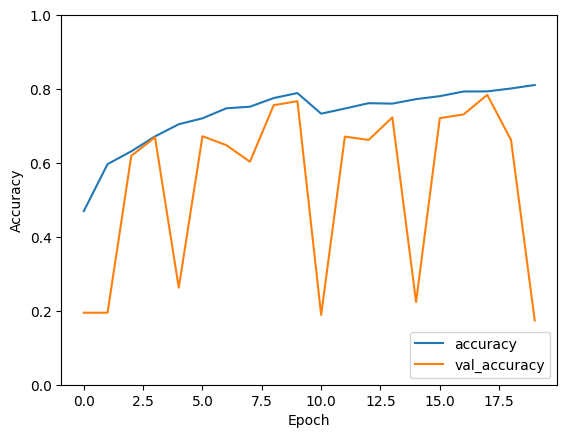

In [57]:
# plotting accuracy of train and validation
import matplotlib.pyplot as plt
mh.model_plot_accuracy(history)
plt.ylim(0,1)

#### F1 Score of train and validation set

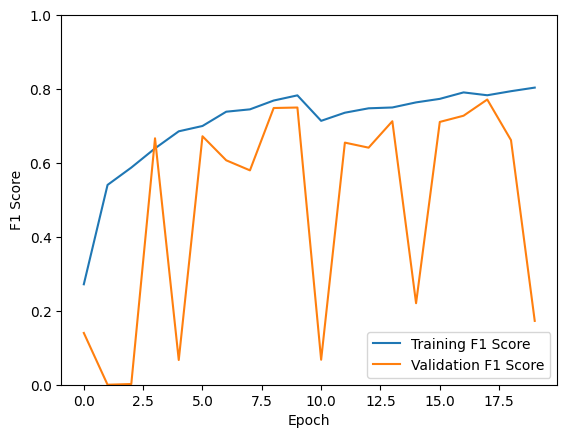

In [58]:
import matplotlib.pyplot as plt

# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

#### Recall of train and validation set

In [60]:
'''import matplotlib.pyplot as plt

# Plot the recall
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.ylim([0, 1])  
plt.legend(loc='lower right')  # adjust the legend position
plt.show()  # Show the plot'''

KeyError: 'recall'

#### Plotting Loss of train and validation set

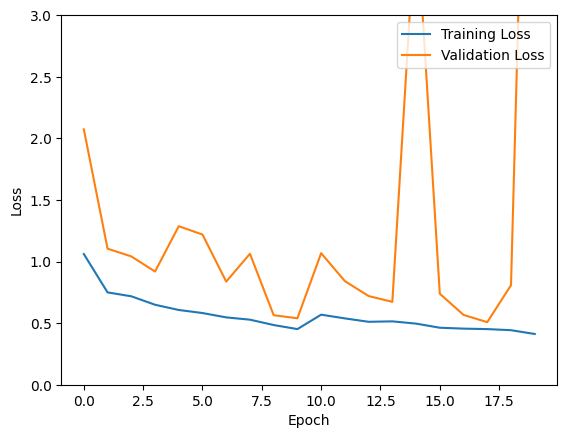

In [64]:
import matplotlib.pyplot as plt

# Plot the loss functions
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


## Evaluating the model on the test set

 > Evaluating model Resnet50_tertiary_augmentation_in_train_data_generator:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 48s 1s/step
 > Model predictions obtained.
 > Macro AUC: 0.6252989710717786
 > Micro AUC: 0.36784415201533066


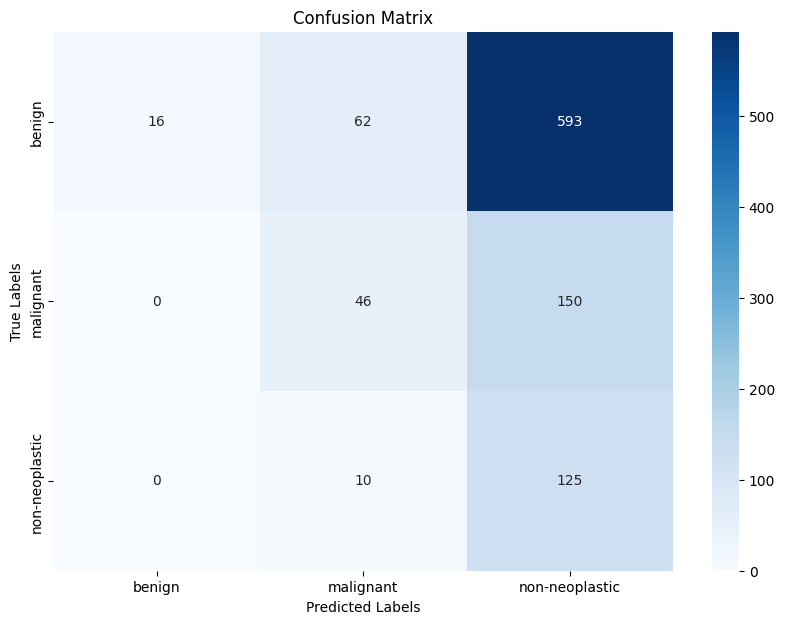



 > Computing classification report...
              precision    recall  f1-score   support

           0       1.00      0.02      0.05       671
           1       0.39      0.23      0.29       196
           2       0.14      0.93      0.25       135

    accuracy                           0.19      1002
   macro avg       0.51      0.39      0.20      1002
weighted avg       0.77      0.19      0.12      1002

 > Evaluating model on test set...
32/32 [==============================] - 47s 1s/step - loss: 9.2685 - accuracy: 0.1866 - f1_score: 0.1874 - recall_1: 0.1866
loss: 9.268519401550293
accuracy: 0.18662674725055695
f1_score: 0.18744656443595886
recall_1: 0.18662674725055695
 > Done.


([{'loss': 9.268519401550293},
  {'accuracy': 0.18662674725055695},
  {'f1_score': 0.18744656443595886},
  {'recall_1': 0.18662674725055695}],
 array([[ 16,  62, 593],
        [  0,  46, 150],
        [  0,  10, 125]]),
 (0.36784415201533066, 0.6252989710717786))

In [65]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [66]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/eigenaarti/Documents/Data_Science/neue_fische/Repositories/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
